### Xception - Stanford Dogs dataset classification

If you like this script, consider adopting a dog, and never abandon yours

![Never abandon a dog](http://www.the-teen-spirit.dk/films/vanwilder/image.jpg)



I will be performing following steps :
1. Importing the data 
2. Data Argumentation And Visualization 
3. Importing the Xception ( Transfer learning ) 
4. Fully Connected layer 
5. Model Training 
6. Accuracy And Loss Visualization
7. Test the model




# **ABOUT THE DATASET **

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.


## 1. DATASET EXPLORATION 

In [12]:
!pip install tf_explain
#!pip install split-folders
#!conda install -y gdown

### 1.1 Libraries and data

In [44]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
#import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

from keras.utils import np_utils
from keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.activations import ExtractActivations

from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
print("Loaded all libraries")

Loaded all libraries


In [2]:
#image_path = '../input/stanford-dogs-dataset/images/Images'
image_path ='/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'
num_of_categories = 120
image_size = 299
batch_size = 16

In [63]:
breed_list = sorted(os.listdir(image_path))

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

120 breeds


In [64]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 1.2 Generate a data folder with cropped pictures 

In [17]:


# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))



Created 120 folders to store cropped images of the different breeds.


In [18]:
%%time
#for breed in os.listdir('data'):
#    for file in os.listdir('/media/marco/DATA/OC_Machine_learning/section_6/DATA/Annotation/{}'.format(breed)):
#        img = Image.open('/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/{}/{}.jpg'.format(breed, file))
#        tree = ET.parse('/media/marco/DATA/OC_Machine_learning/section_6/DATA/Annotation/{}/{}'.format(breed, file))
#        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
#        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
#        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
#        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
#        img = img.crop((xmin, ymin, xmax, ymax))
#        img = img.convert('RGB')
#        img = img.resize((image_size, image_size))
#        img.save('data/' + breed + '/' + file + '.jpg')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


### 1.2.1 Define paths (X) and labels (y)

In [65]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [66]:
label_maps_rev

{0: 'n02085620-Chihuahua',
 1: 'n02085782-Japanese_spaniel',
 2: 'n02085936-Maltese_dog',
 3: 'n02086079-Pekinese',
 4: 'n02086240-Shih-Tzu',
 5: 'n02086646-Blenheim_spaniel',
 6: 'n02086910-papillon',
 7: 'n02087046-toy_terrier',
 8: 'n02087394-Rhodesian_ridgeback',
 9: 'n02088094-Afghan_hound',
 10: 'n02088238-basset',
 11: 'n02088364-beagle',
 12: 'n02088466-bloodhound',
 13: 'n02088632-bluetick',
 14: 'n02089078-black-and-tan_coonhound',
 15: 'n02089867-Walker_hound',
 16: 'n02089973-English_foxhound',
 17: 'n02090379-redbone',
 18: 'n02090622-borzoi',
 19: 'n02090721-Irish_wolfhound',
 20: 'n02091032-Italian_greyhound',
 21: 'n02091134-whippet',
 22: 'n02091244-Ibizan_hound',
 23: 'n02091467-Norwegian_elkhound',
 24: 'n02091635-otterhound',
 25: 'n02091831-Saluki',
 26: 'n02092002-Scottish_deerhound',
 27: 'n02092339-Weimaraner',
 28: 'n02093256-Staffordshire_bullterrier',
 29: 'n02093428-American_Staffordshire_terrier',
 30: 'n02093647-Bedlington_terrier',
 31: 'n02093754-Border_

In [50]:
import pickle
pickle_in = open("labels_dict.pickle","rb")
label_maps_rev = pickle.load(pickle_in)
label_maps_rev

{0: 'n02095570-Lakeland_terrier',
 1: 'n02095314-wire-haired_fox_terrier',
 2: 'n02086910-papillon',
 3: 'n02100877-Irish_setter',
 4: 'n02097658-silky_terrier',
 5: 'n02089078-black-and-tan_coonhound',
 6: 'n02091134-whippet',
 7: 'n02093754-Border_terrier',
 8: 'n02110627-affenpinscher',
 9: 'n02092339-Weimaraner',
 10: 'n02113799-standard_poodle',
 11: 'n02111277-Newfoundland',
 12: 'n02099267-flat-coated_retriever',
 13: 'n02091032-Italian_greyhound',
 14: 'n02102318-cocker_spaniel',
 15: 'n02086646-Blenheim_spaniel',
 16: 'n02096585-Boston_bull',
 17: 'n02092002-Scottish_deerhound',
 18: 'n02096437-Dandie_Dinmont',
 19: 'n02104029-kuvasz',
 20: 'n02097209-standard_schnauzer',
 21: 'n02096294-Australian_terrier',
 22: 'n02085782-Japanese_spaniel',
 23: 'n02111500-Great_Pyrenees',
 24: 'n02087394-Rhodesian_ridgeback',
 25: 'n02110063-malamute',
 26: 'n02107683-Bernese_mountain_dog',
 27: 'n02091831-Saluki',
 28: 'n02112706-Brabancon_griffon',
 29: 'n02094114-Norfolk_terrier',
 30: '

In [20]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "/media/marco/DATA/OC_Machine_learning/section_6/DATA/data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

### 1.3 Define my own image generator with custom augmentation

In [21]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Sometimes(0.5,
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

### 1.4 Split X and y into train, validation and test

In [22]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

## 2. MODEL PREPARATION 

### 2.1 Importing the Xception CNN

In [23]:


#url = 'https://drive.google.com/uc?id=1aCFGR5c7Ap4JPzryR_RSgRYc7FRYgbyG'

#output = 'xception_weights.h5'

#gdown.download(url, output, quiet=False)

In [45]:
tf.random.set_seed(42)

pre_trained_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')#Summary of Xception Model

pre_trained_model.trainable = False


pre_trained_model.summary()



Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### 2.2 Fully connected layer

In [54]:
flat_dim = 5 * 5 * 2048

my_model = Sequential(pre_trained_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
pre_trained_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
pre_trained_model.add(Dropout(0.2))
pre_trained_model.add(Dense(256, activation='relu'))
pre_trained_model.add(Dropout(0.2))
pre_trained_model.add(Dense(120, activation='softmax'))



AttributeError: 'Model' object has no attribute 'add'

### 2.3 Define callbacks and compile the model

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


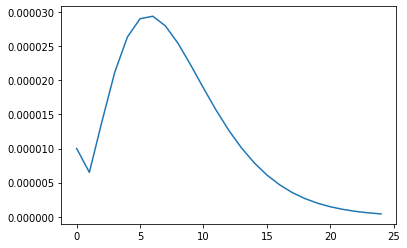

In [39]:
###################
total_epoch = 8
learning_rate_init = 0.00001
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [40]:
# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 6, mode='max', min_delta=1, verbose=1)

In [41]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 3. TRAINING THE MODEL

In [29]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=400, validation_data=val_ds,  validation_steps=90, epochs=total_epoch, callbacks=[scheduler])

      

In [ ]:
          

time_elapsed()

### 4. LOSS AND ACCURACY VISUALIZATION 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5. Save model and parameters

In [ ]:

pre_trained_model.save_weights('dog_breed_xcept_weights.h5', overwrite=True)
print("Saved model to disk")

### 6. Test model accuracy

In [44]:

#my_model.load_weights("/media/marco/DATA/OC_Machine_learning/section_6/DATA/dog_breed_xcept_weights.h5")


In [33]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

In [ ]:

#report = classification_report(test_ds.classes, pred, target_names=class_to_id)
#print(report)

## 7. Predict new images

In [57]:
model1 = tf.keras.models.load_model("/media/marco/DATA/OC_Machine_learning/section_6/DATA/my_model.h5")

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_3 (Dense)              (None, 1032)              2114568   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               264448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               30840     
Total params: 23,271,336
Trainable params: 2,409,856
Non-trainable params: 20,861,480
__________________________________

In [58]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = model1.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

73.39% 	 malinois
4.87% 	 kelpie
3.10% 	 German_shepherd
2.71% 	 African_hunting_dog
1.53% 	 Ibizan_hound


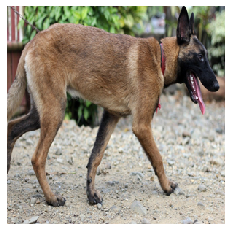

In [60]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")



23.18% 	 Brittany_spaniel
17.93% 	 Blenheim_spaniel
16.05% 	 Welsh_springer_spaniel
6.53% 	 golden_retriever
4.48% 	 Irish_setter


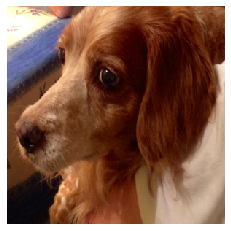

In [61]:
download_and_predict("http://giandonet.altervista.org/Marco/ala.JPG",
                     "test_2.jpg")
